In [18]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from adahessian import Adahessian, get_params_grad
import torch.utils.data as data_utils
import torch.optim.lr_scheduler as lr_scheduler
from UCI_loader import UCIDatasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [18]:
dataClass= UCIDatasets("power", data_path="", n_splits=10) # has a field named 'data' that contains the data

trainData= dataClass.get_split(train=True)
trainLoader= torch.utils.data.DataLoader(trainData, batch_size=64, shuffle= True) # creating a loader with full batch size to ensure LBFGS works
trainLoaderLBFGS= torch.utils.data.DataLoader(trainData, batch_size= dataClass.data.shape[0], shuffle= True) # creating a loader with full batch size to ensure LBFGS works
testData= dataClass.get_split(train= False)
testLoader= torch.utils.data.DataLoader(testData, batch_size= 64, shuffle= True)
testLoaderLBFGS= torch.utils.data.DataLoader(testData, batch_size= dataClass.data.shape[0], shuffle= True)

FileNotFoundError: [Errno 2] No such file or directory: 'UCI/CCPP/Folds5x2_pp.xlsx'

In [59]:
dataset= "./Datasets/Regression/california.csv"
x_cols = list(range(9))
y_col = 9
separator = ","
remove_head = False


# attribute_index =   # This controls which attribute is allowed to vary, 7,5
attribute_name = "BMI" # Name of the attribute, used in the plots, max heart rate
latent_name = "Diabetes" # Name of the function, used in the plots
# The other attributes are replaced by the median value of the attribute
Scaler= StandardScaler()
batch_is= 64

total_epochs = 20

### 
def create_xy(dataset, attribute_columns, target_column, delim, split_ratio, ditch_head=True):
    with open(dataset, 'r') as f:
        lines = f.readlines()
    if ditch_head:
        lines = lines[1:]
    X = []
    Y = []
    for line in lines:
        while len(line) > 0 and line[-1] == "\n":
            line = line[:len(line)-1]
        split_array = line.split(delim)
        all_columns = []
        for value in split_array:
            if value !="" and value !=" ":
                all_columns.append(value)
        if len(all_columns)==0:
            break
        point = []
        for i in attribute_columns:
            point.append(float(all_columns[i]))
        X.append(point)
        Y.append(float(all_columns[target_column]))
    X_arr = np.asarray(X)
    X_unscaled = np.asarray(X)
    Scaler.fit(X_arr)
    X_arr = Scaler.transform(X_arr)
    Y_arr = np.asarray(Y)
    thresh = 0
    # Y_arr_binary = np.where(Y_arr<=thresh,0,1)
    # unique, counts = np.unique(Y_arr_binary, return_counts=True)
    x_train, x_test, y_train, y_test = train_test_split(X_arr, Y_arr, test_size = split_ratio)
    return x_train, x_test, y_train, y_test, Y_arr, X_arr, X_unscaled, X_arr.shape[0]

###
X_train,X_val,y_train,y_val, data_Y, data_X_scaled, data_X_unscaled, full= create_xy(dataset, x_cols, y_col, separator, 0.4, ditch_head= remove_head)
shap_x_train = X_train.copy()
shap_x_val = X_val.copy()
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
# y_train= F.one_hot(y_train.to(torch.int64), num_classes=2)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
# y_val= F.one_hot(y_val.to(torch.int64), num_classes=2)
train_dataset = data_utils.TensorDataset(X_train, y_train)
test_dataset = data_utils.TensorDataset(X_val, y_val)
trainLoader= data_utils.DataLoader(train_dataset, batch_size= batch_is, pin_memory=True,shuffle=True,num_workers = 1)
trainLoaderLBFGS= data_utils.DataLoader(train_dataset, batch_size=full, pin_memory=True,shuffle=True,num_workers = 1)
testLoader= data_utils.DataLoader(test_dataset,batch_size= batch_is,pin_memory=True,shuffle = False,num_workers = 1)


IndexError: list index out of range

In [40]:
data_batch, labels_batch = next(iter(trainLoader))
try:
    inDim, outDim= data_batch.shape[1], labels_batch.shape[1]
except IndexError:
    inDim, outDim= data_batch.shape[1], 1


In [41]:
# defining all the criterions to be used in the following experiments:
def tiltedLC(x, y, tau, h):
    e= y-x # errors
    ind= (torch.sign(e)+1)/2 # the division in the log-cosh is only about the origin
    quantFactor= (1-tau)*(1-ind) + tau*ind
    loss= quantFactor*torch.log(torch.cosh(e))
    loss= torch.mean(loss)
    return loss

class TiltedLC(nn.Module):
    def __init__(self):
        super(TiltedLC, self).__init__()
    def forward(self, x, y, tau, h):
        return tiltedLC(x, y, tau, h)

In [42]:
# global initialisations:
h= 0.4 # smoothing parameter for the log-cosh 
tau= 0.5
device= ('cuda' if torch.cuda.is_available() else 'cpu')
criterion1= TiltedLC()
criterion2= nn.MSELoss()
criterion3= nn.L1Loss()
N_EPOCHS= 100

In [43]:
class LALRnetwork(nn.Module):
    def __init__(self, size1, size2, inDim, outDim, drop):
        super(LALRnetwork, self).__init__()
        self.l1= nn.Linear(inDim, size1)
        self.l2= nn.Dropout(p= drop)
        self.l3= nn.Linear(size1, size2)
        self.l4= nn.Dropout(p= drop)
        self.l5= nn.Linear(size2, outDim)

    def forward(self, x):
        x= F.tanh(self.l1(x))
        x= F.tanh(self.l3(self.l2(x)))
        x= self.l5(self.l4(x))
        return x
    
    def penU(self, x):
        x= F.tanh(self.l2(self.l1(x)))
        x= F.tanh(self.l4(self.l3(x)))
        return x

In [48]:
size1, size2= 300, 300
model_LBFGS_LC= LALRnetwork(size1, size2, inDim, outDim, 0.1).to(device)
optimizer_LBFGS_LC= optim.LBFGS(model_LBFGS_LC.parameters())
lossList_LBFGS_LC= []
valList_LBFGS_LC= []

model_LBFGS_MSE= LALRnetwork(size1, size2, inDim, outDim, 0.1).to(device)
optimizer_LBFGS_MSE= optim.LBFGS(model_LBFGS_MSE.parameters())
lossList_LBFGS_MSE= []
valList_LBFGS_MSE= []

model_CLR_L1= LALRnetwork(size1, size2, inDim, outDim, 0.1).to(device)
optimizer_CLR_L1= optim.Adam(model_CLR_L1.parameters(), lr= 0.1)
lossList_CLR_L1= []
valList_CLR_L1= []

model_CLR_LC= LALRnetwork(size1, size2, inDim, outDim, 0.1).to(device)
optimizer_CLR_LC= optim.Adam(model_CLR_LC.parameters(), lr= 0.1)
lossList_CLR_LC= []
valList_CLR_LC= []

model_CLR_MSE= LALRnetwork(size1, size2, inDim, outDim, 0.1).to(device)
optimizer_CLR_MSE= optim.Adam(model_CLR_MSE.parameters(), lr= 0.1)
lossList_CLR_MSE= []
valList_CLR_MSE= []

model_LALR_L1= LALRnetwork(size1, size2, inDim, outDim, 0.1).to(device)
optimizer_LALR_L1= optim.Adam(model_LALR_L1.parameters(), lr= 0.1)
lossList_LALR_L1= []
valList_LALR_L1= []

model_LALR_LC= LALRnetwork(size1, size2, inDim, outDim, 0.1).to(device)
optimizer_LALR_LC= optim.Adam(model_LALR_LC.parameters(), lr= 0.1)
lossList_LALR_LC= []
valList_LALR_LC= []

model_LALR_MSE= LALRnetwork(size1, size2, inDim, outDim, 0.1).to(device)
optimizer_LALR_MSE= optim.Adam(model_LALR_MSE.parameters(), lr= 0.1)
lossList_LALR_MSE= []
valList_LALR_MSE= []

In [49]:
def trainLBFGS(model, optimizer, criterion, tau, epochs, ls_list, valList, loss_name):
    """
    Training loop used for LBFGS and conjugate gradient training
    """
    for epoch in range(epochs):
        epoch_loss= 0.0
        # training loop
        model.train()
        for inputs, labels in trainLoaderLBFGS: 
            inputs= inputs.to(device) 
            labels= labels.to(device)
            def closure():
                optimizer.zero_grad()
                outputs= model(inputs)
                if loss_name== "MSE":
                    loss= criterion(outputs, labels)
                else:
                    loss= criterion(outputs, labels, tau, h)
                loss.backward()
                return loss
            optimizer.step(closure) 
        # ls_list.append(epoch_loss/len(trainLoader))

        # validation loop
        val_loss= 0.0
        model.eval()
        for inputs, labels in testLoader:
            inputs= inputs.to(device)
            labels= labels.to(device)
            outputs= model(inputs)
            loss= torch.sqrt(criterion2(outputs, labels))
            val_loss+= loss.item()
        valList.append(val_loss/len(testLoader))
        print("Epoch: {} Training loss: {} Validation loss: {}".format(epoch, epoch_loss/len(trainLoader), val_loss/len(testLoader)))
        
def trainConstantLR(model, optimizer, criterion, tau, epochs, ls_list, valList, loss_name):
    """
    Training loop used for constantLR
    """
    for epoch in range(epochs):
        epoch_loss= 0.0
        # training loop
        model.train()
        for inputs, labels in trainLoader: 
            inputs= inputs.to(device) 
            labels= labels.to(device)
            optimizer.zero_grad() 
            outputs= model(inputs) 
            if loss_name== "LC":
                loss= criterion(outputs, labels, tau, h)
            else:
                loss= criterion(outputs, labels)
            loss.backward()
            optimizer.step() 
            epoch_loss+= loss.item()
        ls_list.append(epoch_loss/len(trainLoader))

        # validation loop
        val_loss= 0.0
        model.eval()
        for inputs, labels in testLoader:
            inputs= inputs.to(device)
            labels= labels.to(device)
            outputs= model(inputs)
            loss= torch.sqrt(criterion2(outputs, labels))
            val_loss+= loss.item()
        valList.append(val_loss/len(testLoader))
        print("Epoch: {} Training loss: {} Validation loss: {}".format(epoch, epoch_loss/len(trainLoader), val_loss/len(testLoader)))

def trainLALR(model,optimizer, criterion,  tau, epochs, ls_list, valList, loss_name):
    """
    Training loop used for LALR training
    """
    for epoch in range(epochs):
        epoch_loss= 0.0
        lr_val= computeLR(model, loss_name, bSize=16)
        optimizer.param_groups[0]['lr']= lr_val
        # training loop
        model.train()
        for inputs, labels in trainLoader:
            inputs= inputs.to(device)
            labels= labels.to(device)
            optimizer.zero_grad()
            outputs= model(inputs)
            if loss_name == "LC":
                loss= criterion(outputs, labels, tau, h)
            else:
                loss= criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss+= loss.item()
        ls_list.append(epoch_loss/len(trainLoader))

        # validation loop
        val_loss= 0.0
        model.eval()
        for inputs, labels in testLoader:
            inputs= inputs.to(device)
            labels= labels.to(device)
            outputs= model(inputs)
            loss= torch.sqrt(criterion2(outputs, labels))
            val_loss+= loss.item()
        valList.append(val_loss/len(testLoader))
        print("Epoch: {} Training Loss: {} Validation loss: {} LR: {}".format(epoch, epoch_loss/len(trainLoader), val_loss/len(testLoader), optimizer.param_groups[0]['lr']))

In [50]:
# Learning rate computation functions:
def computeKa(x):
    maxNorm= 0.0
    for vector in x:
        if (maxNorm < torch.linalg.vector_norm(vector)):
            maxNorm= torch.linalg.vector_norm(vector)
    return maxNorm

def computeLR(model, ls, bSize= 16):
    """
    Takes in a network of the LALRnetwork class(during some arbitrary EPOCH of training) and the current input, and returns Kz for the EPOCH
    """
    Kz = 0.0
    Ka= 0.0
    Y= 0.0
    z_k= 0.0
    model.eval()
    with torch.no_grad():
        for i,j in enumerate(trainLoader):
            inputs,labels= j[0],j[1]
            inputs= inputs.to(device)
            labels= labels.to(device)
            op1= model.penU(inputs)
            op2= model(inputs)
            # first taking the max and min for each batch
            val1= torch.linalg.norm(op1)
            # activ1, arg1= torch.max(op1, dim= 1)
            activ2, arg2= torch.min(op2, dim= 1)
            # now, we take the max and min across batches
            # val1, indx1= torch.max(activ1, dim= 0)
            val2, indx2= torch.min(activ2, dim= 0)
            val3= computeKa(op2)
            val4= computeKa(labels)
            # print(indx, i)
            if val1 > Kz:
                # in the case of K_z, we do not need the index where the max occurs, hence only deal with the value
                Kz= val1 
            z_k= val2
            if val3 > Ka:
                Ka= val3
            if val3 > Y:
                Y= val4 
            argMin= arg2[indx2]

    LR= 1
    factor= 1
    if ls == "LC":
        # LR= (1/bSize)*torch.tanh(-op2[int(indx2)][int(argMin)])*Kz
        LR= (1/bSize)*Kz*torch.tanh(val4)
        factor= 0.1
    elif ls == "L1":
        LR= Kz/bSize
    elif ls == "MSE":
        LR= (1/bSize)*(Ka+Y)*Kz

    if LR==0:
        return 0.1
    return (1/LR)*factor

In [58]:
# LBFGS, LC
trainLBFGS(model_LBFGS_LC, optimizer_LBFGS_LC, criterion1, tau,  N_EPOCHS, lossList_LBFGS_LC, valList_LBFGS_LC, "LC")

Epoch: 0 Training loss: 0.0 Validation loss: 9.895125031471252
Epoch: 1 Training loss: 0.0 Validation loss: 9.872456908226013
Epoch: 2 Training loss: 0.0 Validation loss: 9.870267629623413
Epoch: 3 Training loss: 0.0 Validation loss: 9.861825466156006
Epoch: 4 Training loss: 0.0 Validation loss: 9.860758781433105
Epoch: 5 Training loss: 0.0 Validation loss: 9.855895757675171
Epoch: 6 Training loss: 0.0 Validation loss: 9.861916422843933
Epoch: 7 Training loss: 0.0 Validation loss: 9.854797959327698
Epoch: 8 Training loss: 0.0 Validation loss: 9.859606266021729
Epoch: 9 Training loss: 0.0 Validation loss: 9.857123136520386
Epoch: 10 Training loss: 0.0 Validation loss: 9.873890280723572
Epoch: 11 Training loss: 0.0 Validation loss: 9.864315509796143
Epoch: 12 Training loss: 0.0 Validation loss: 9.869473695755005
Epoch: 13 Training loss: 0.0 Validation loss: 9.854023456573486
Epoch: 14 Training loss: 0.0 Validation loss: 9.860597372055054
Epoch: 15 Training loss: 0.0 Validation loss: 9.86

In [51]:
# LBFGS, MSE
trainLBFGS(model_LBFGS_MSE, optimizer_LBFGS_MSE, criterion2, tau,  N_EPOCHS, lossList_LBFGS_MSE, valList_LBFGS_MSE, "MSE")

/home/aryamanj/miniconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([303])) that is different to the input size (torch.Size([303, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 Training loss: 0.0 Validation loss: 9.771556854248047
Epoch: 1 Training loss: 0.0 Validation loss: 9.753222107887268
Epoch: 2 Training loss: 0.0 Validation loss: 9.713550209999084
Epoch: 3 Training loss: 0.0 Validation loss: 9.706040620803833
Epoch: 4 Training loss: 0.0 Validation loss: 9.725767135620117
Epoch: 5 Training loss: 0.0 Validation loss: 9.719310760498047
Epoch: 6 Training loss: 0.0 Validation loss: 9.724807024002075
Epoch: 7 Training loss: 0.0 Validation loss: 9.70846140384674
Epoch: 8 Training loss: 0.0 Validation loss: 9.709206938743591
Epoch: 9 Training loss: 0.0 Validation loss: 9.714798331260681
Epoch: 10 Training loss: 0.0 Validation loss: 9.717642068862915
Epoch: 11 Training loss: 0.0 Validation loss: 9.718194127082825
Epoch: 12 Training loss: 0.0 Validation loss: 9.716617703437805
Epoch: 13 Training loss: 0.0 Validation loss: 9.714474201202393
Epoch: 14 Training loss: 0.0 Validation loss: 9.71360445022583
Epoch: 15 Training loss: 0.0 Validation loss: 9.7132

In [52]:
# CLR, MAE:
trainConstantLR(model_CLR_L1, optimizer_CLR_L1, criterion3, tau,  N_EPOCHS, lossList_CLR_L1, valList_CLR_L1, "L1")

/home/aryamanj/miniconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/aryamanj/miniconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([47])) that is different to the input size (torch.Size([47, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 0 Training loss: 20.22290382385254 Validation loss: 16.227161407470703
Epoch: 1 Training loss: 15.574099159240722 Validation loss: 18.1910080909729
Epoch: 2 Training loss: 9.396281147003174 Validation loss: 14.96127986907959
Epoch: 3 Training loss: 7.345251846313476 Validation loss: 10.014607906341553
Epoch: 4 Training loss: 6.702865695953369 Validation loss: 9.800524353981018
Epoch: 5 Training loss: 6.807854270935058 Validation loss: 10.254472255706787
Epoch: 6 Training loss: 6.653886985778809 Validation loss: 9.740045189857483
Epoch: 7 Training loss: 6.675432777404785 Validation loss: 9.743155837059021
Epoch: 8 Training loss: 6.670226287841797 Validation loss: 9.89651894569397
Epoch: 9 Training loss: 6.605729484558106 Validation loss: 9.676557540893555
Epoch: 10 Training loss: 6.638999938964844 Validation loss: 9.690563440322876
Epoch: 11 Training loss: 7.35370454788208 Validation loss: 10.988174676895142
Epoch: 12 Training loss: 8.260419845581055 Validation loss: 9.7414224147

In [53]:
# CLR, MSE
trainConstantLR(model_CLR_MSE, optimizer_CLR_MSE, criterion2, tau,  N_EPOCHS, lossList_CLR_MSE, valList_CLR_MSE, "MSE")

/home/aryamanj/miniconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([47])) that is different to the input size (torch.Size([47, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 Training loss: 628.5410583496093 Validation loss: 20.348630905151367
Epoch: 1 Training loss: 269.8549865722656 Validation loss: 13.101255178451538
Epoch: 2 Training loss: 157.23284301757812 Validation loss: 11.00379753112793
Epoch: 3 Training loss: 112.60870666503907 Validation loss: 10.223612546920776
Epoch: 4 Training loss: 93.40291442871094 Validation loss: 9.845509767532349
Epoch: 5 Training loss: 90.85623779296876 Validation loss: 9.76801073551178
Epoch: 6 Training loss: 87.01457977294922 Validation loss: 9.863399505615234
Epoch: 7 Training loss: 86.20083312988281 Validation loss: 9.767314910888672
Epoch: 8 Training loss: 84.21981506347656 Validation loss: 9.690276026725769
Epoch: 9 Training loss: 84.03750610351562 Validation loss: 9.701805233955383
Epoch: 10 Training loss: 85.85609893798828 Validation loss: 9.772770166397095
Epoch: 11 Training loss: 86.06941070556641 Validation loss: 9.683846592903137
Epoch: 12 Training loss: 84.8620590209961 Validation loss: 9.792319655

In [54]:
# CLR, LC
trainConstantLR(model_CLR_LC, optimizer_CLR_LC, criterion1, tau,  N_EPOCHS, lossList_CLR_LC, valList_CLR_LC, "LC")

Epoch: 0 Training loss: 11.746970844268798 Validation loss: 28.15874147415161
Epoch: 1 Training loss: 7.524914121627807 Validation loss: 14.270958423614502
Epoch: 2 Training loss: 4.464273262023926 Validation loss: 13.351861953735352
Epoch: 3 Training loss: 4.1195387840271 Validation loss: 11.22227668762207
Epoch: 4 Training loss: 3.428277063369751 Validation loss: 10.634599208831787
Epoch: 5 Training loss: 3.3093474388122557 Validation loss: 10.996006846427917
Epoch: 6 Training loss: 3.2050366401672363 Validation loss: 10.244851112365723
Epoch: 7 Training loss: 3.185597467422485 Validation loss: 9.831474542617798
Epoch: 8 Training loss: 3.1512866973876954 Validation loss: 10.135895252227783
Epoch: 9 Training loss: 3.0762972831726074 Validation loss: 10.427598118782043
Epoch: 10 Training loss: 3.002963066101074 Validation loss: 9.82954216003418
Epoch: 11 Training loss: 2.9512307167053224 Validation loss: 9.854008674621582
Epoch: 12 Training loss: 2.9240466594696044 Validation loss: 9.9

In [55]:
# LALR, LC
trainLALR(model_LALR_LC, optimizer_LALR_LC, criterion1, tau,  N_EPOCHS, lossList_LALR_LC, valList_LALR_LC, "LC")

Epoch: 0 Training Loss: 6.296551513671875 Validation loss: 11.224769830703735 LR: 0.045352753251791
Epoch: 1 Training Loss: 3.6325222492218017 Validation loss: 10.091965556144714 LR: 0.011749116703867912
Epoch: 2 Training Loss: 3.1882354259490966 Validation loss: 10.866821885108948 LR: 0.011659768410027027
Epoch: 3 Training Loss: 3.0330012321472166 Validation loss: 9.74666976928711 LR: 0.01162084098905325
Epoch: 4 Training Loss: 3.0073118209838867 Validation loss: 9.757845282554626 LR: 0.011616628617048264
Epoch: 5 Training Loss: 2.9212725162506104 Validation loss: 10.048588633537292 LR: 0.011630753055214882
Epoch: 6 Training Loss: 2.923072576522827 Validation loss: 9.993490099906921 LR: 0.011627797968685627
Epoch: 7 Training Loss: 2.937275505065918 Validation loss: 9.719716429710388 LR: 0.011625432409346104
Epoch: 8 Training Loss: 2.9435542583465577 Validation loss: 9.957775473594666 LR: 0.011621377430856228
Epoch: 9 Training Loss: 2.9190475940704346 Validation loss: 9.997872471809387

In [56]:
# LALR, MSE
trainLALR(model_LALR_MSE, optimizer_LALR_MSE, criterion2, tau,  N_EPOCHS, lossList_LALR_MSE, valList_LALR_MSE, "MSE")

Epoch: 0 Training Loss: 390.4385192871094 Validation loss: 12.94198489189148 LR: 0.008804201148450375
Epoch: 1 Training Loss: 119.33902740478516 Validation loss: 10.953763365745544 LR: 0.0019581054802984
Epoch: 2 Training Loss: 93.26563262939453 Validation loss: 9.86756718158722 LR: 0.0021676404867321253
Epoch: 3 Training Loss: 82.06964950561523 Validation loss: 9.680711507797241 LR: 0.0016715467208996415
Epoch: 4 Training Loss: 82.95601119995118 Validation loss: 9.69076418876648 LR: 0.0016192805487662554
Epoch: 5 Training Loss: 84.82884979248047 Validation loss: 9.699005603790283 LR: 0.0015972956316545606
Epoch: 6 Training Loss: 85.85055694580078 Validation loss: 9.677596807479858 LR: 0.001593135530129075
Epoch: 7 Training Loss: 83.572314453125 Validation loss: 9.677178025245667 LR: 0.0016006232472136617
Epoch: 8 Training Loss: 85.22699584960938 Validation loss: 9.709229826927185 LR: 0.0016145985573530197
Epoch: 9 Training Loss: 83.54543762207031 Validation loss: 9.744696736335754 LR:

In [57]:
# LALR, MAE
trainLALR(model_LALR_L1, optimizer_LALR_L1, criterion3, tau,  N_EPOCHS, lossList_LALR_L1, valList_LALR_L1, "L1")

Epoch: 0 Training Loss: 44.39178123474121 Validation loss: 32.33310413360596 LR: 0.4528968930244446
Epoch: 1 Training Loss: 22.2152458190918 Validation loss: 19.454655170440674 LR: 0.11593209207057953
Epoch: 2 Training Loss: 12.12131862640381 Validation loss: 16.36980938911438 LR: 0.1158185750246048
Epoch: 3 Training Loss: 11.074598121643067 Validation loss: 13.057222843170166 LR: 0.11568094044923782
Epoch: 4 Training Loss: 8.14787769317627 Validation loss: 11.451771259307861 LR: 0.11564849317073822
Epoch: 5 Training Loss: 7.393148517608642 Validation loss: 11.277796030044556 LR: 0.11562307924032211
Epoch: 6 Training Loss: 7.302708148956299 Validation loss: 11.026631712913513 LR: 0.11558429896831512
Epoch: 7 Training Loss: 6.991545581817627 Validation loss: 10.72295618057251 LR: 0.11560175567865372
Epoch: 8 Training Loss: 7.115063190460205 Validation loss: 10.191576361656189 LR: 0.11556382477283478
Epoch: 9 Training Loss: 6.819791412353515 Validation loss: 10.176325678825378 LR: 0.1155

No handles with labels found to put in legend.


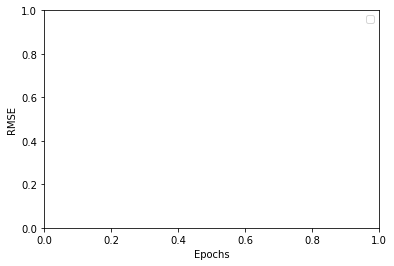

In [268]:
# plt.plot(range(100), valList_LBFGS_LC, label="Log-Cosh-LBFGS")
# plt.plot(range(100), valList_LBFGS_MSE, label="MSE-LBFGS")
# plt.plot(range(100), valList_CLR_MSE, label="CLR-MSE_adam")
# plt.plot(range(100), valList_LALR_MSE, label="LALR-MSE_adam")
# plt.plot(range(100), valList_CLR_L1, label="CLR-L1_adam")
# plt.plot(range(100), valList_LALR_L1, label="LALR-L1_adam")
# plt.plot(range(100), valList_LALR_LC, label="LALR-LC_adam")
# plt.plot(range(100), valList_CLR_LC, label="CLR-LC_adam")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()

In [215]:
valList_CLR_LC[-1]

17.45429801940918